<a href="https://colab.research.google.com/github/raymanhuang/skin_disease_classifier/blob/main/skin_disease_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "skin_diseases"

if image_path.is_dir():
  print(f"{image_path} dir exists")
else:
  print(f"did not find dir, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

did not find dir, creating...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/skin_diseases.zip"

'/content/drive/My Drive/skin_diseases.zip'


In [4]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
!7z x "/content/drive/My Drive/skin_diseases.zip" -o"./data/skin_diseases/"

In [6]:
import torch
from torch import nn

In [7]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

#1. Data Visualization

In [8]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [9]:
from pathlib import Path

In [10]:
data_path = Path("data/")

In [11]:
image_path = Path("./data/skin_diseases/skin_diseases")

In [12]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/skin_diseases/skin_diseases'
There are 5 directories and 0 images in 'data/skin_diseases/skin_diseases/train'
There are 0 directories and 1020 images in 'data/skin_diseases/skin_diseases/train/3.Pigment'
There are 0 directories and 4070 images in 'data/skin_diseases/skin_diseases/train/1.Eczema'
There are 0 directories and 2149 images in 'data/skin_diseases/skin_diseases/train/2.Acne'
There are 0 directories and 10888 images in 'data/skin_diseases/skin_diseases/train/4.Benign'
There are 0 directories and 6783 images in 'data/skin_diseases/skin_diseases/train/5.Malign'
There are 5 directories and 0 images in 'data/skin_diseases/skin_diseases/test'
There are 0 directories and 136 images in 'data/skin_diseases/skin_diseases/test/3.Pigment'
There are 0 directories and 510 images in 'data/skin_diseases/skin_diseases/test/1.Eczema'
There are 0 directories and 322 images in 'data/skin_diseases/skin_diseases/test/2.Acne'
There are 0 directories and

In [13]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

image_path, train_dir, test_dir

(PosixPath('data/skin_diseases/skin_diseases'),
 PosixPath('data/skin_diseases/skin_diseases/train'),
 PosixPath('data/skin_diseases/skin_diseases/test'))

Random image path: data/skin_diseases/skin_diseases/train/4.Benign/4.Benign_4857_1692243027.jpg
Image class: 4
Image height: 450
Image width: 600


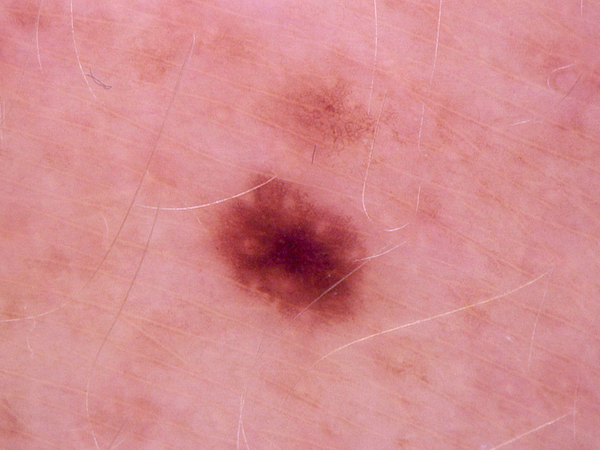

In [14]:
import random
from PIL import Image

# Set seed
random.seed(4)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: 4 | Image shape: (450, 600, 3) -> HWCC')

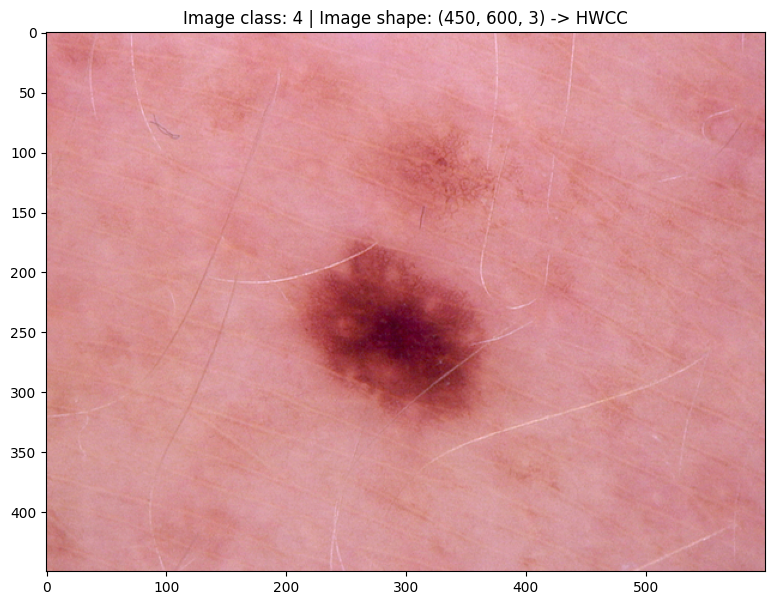

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> HWCC")

# 3. Transforming Data

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [17]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

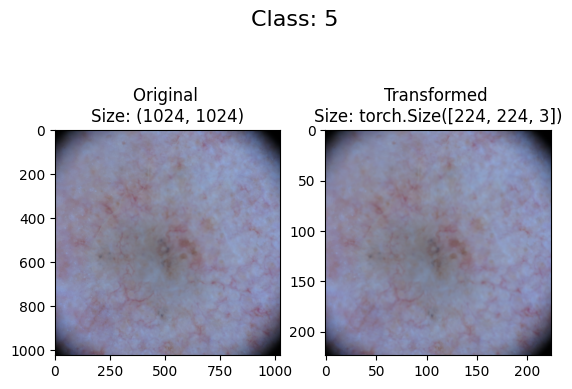

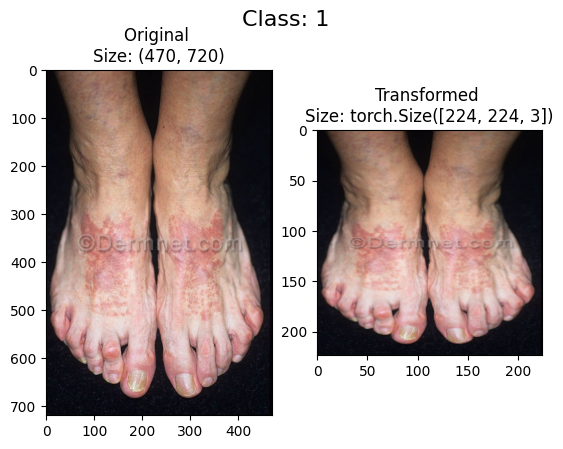

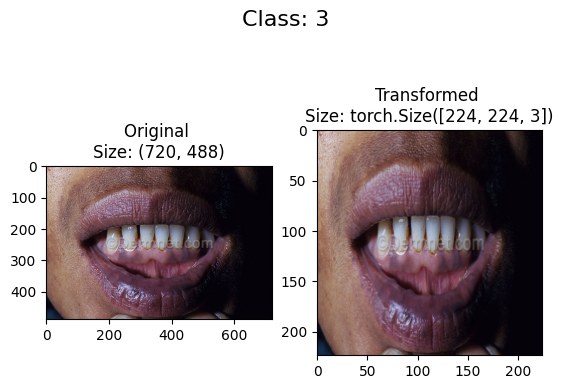

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
       fig, ax = plt.subplots(1, 2)
       ax[0].imshow(f)
       ax[0].set_title(f"Original \nSize: {f.size}")
      #  ax[0].axis("off")

       # Transform and plot image
       # Note: permute() will change shape of image to suit matplotlib
       # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
       transformed_image = transform(f).permute(1, 2, 0)
       ax[1].imshow(transformed_image)
       ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      #  ax[1].axis("off")

       fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


In [19]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 24909
    Root location: data/skin_diseases/skin_diseases/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 3178
    Root location: data/skin_diseases/skin_diseases/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [20]:
class_names = train_data.classes
class_names

['1.Eczema', '2.Acne', '3.Pigment', '4.Benign', '5.Malign']

In [21]:
class_dict = train_data.class_to_idx
class_dict

{'1.Eczema': 0, '2.Acne': 1, '3.Pigment': 2, '4.Benign': 3, '5.Malign': 4}

In [22]:
len(train_data), len(test_data)

(24909, 3178)

In [23]:
from collections import Counter

# Count the occurrences of each class in the training set
train_counts = Counter(train_data.targets)
# Map the class indices to their actual labels
train_class_counts = {train_data.classes[key]: value for key, value in train_counts.items()}

# Count the occurrences of each class in the test set
test_counts = Counter(test_data.targets)
# Map the class indices to their actual labels
test_class_counts = {test_data.classes[key]: value for key, value in test_counts.items()}

print("Training data class distribution:")
for key, value in train_class_counts.items():
    print(f"{key}: {value}")

print("\nTest data class distribution:")
for key, value in test_class_counts.items():
    print(f"{key}: {value}")

Training data class distribution:
1.Eczema: 4070
2.Acne: 2148
3.Pigment: 1020
4.Benign: 10888
5.Malign: 6783

Test data class distribution:
1.Eczema: 510
2.Acne: 322
3.Pigment: 136
4.Benign: 1361
5.Malign: 849


In [24]:
from typing import Tuple, Dict, List
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"for displaying, n should be <10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

In [25]:
class_names

['1.Eczema', '2.Acne', '3.Pigment', '4.Benign', '5.Malign']

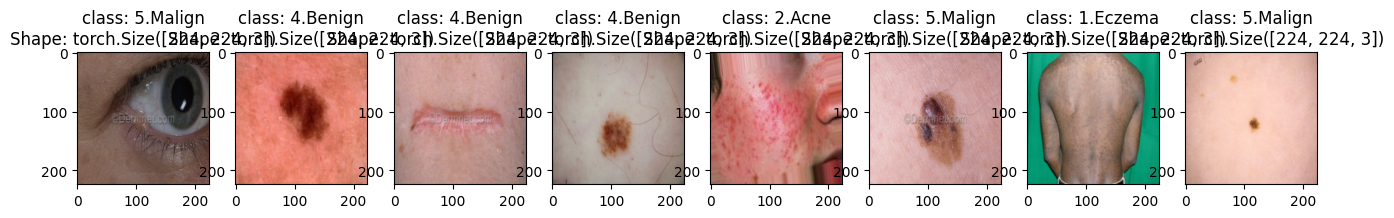

In [26]:
display_random_images(train_data,
                      n=8,
                      classes=class_names,
                      seed=None)

In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bbc84d82290>,
 <torch.utils.data.dataloader.DataLoader at 0x7bbc84d83d00>)

### Building the Model

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [29]:
# Using resnet50 pretrained model
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 254MB/s]


In [30]:
# Number of features in the bottleneck layer
num_ftrs = model.fc.in_features

# Modify output layer
model.fc = nn.Linear(num_ftrs, 5)

### Definining loss function, optim, device

In [31]:
# Define the loss function (criterion)
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Try a forward pass

In [32]:

images, labels = next(iter(train_dataloader))  # This will fetch the first batch.

import random

random_idx = random.choice(range(images.shape[0]))
single_image = images[random_idx].unsqueeze(0).to(device)  # Add back the batch dimension
label = labels[random_idx].item()

model.eval()
with torch.no_grad():  # No need to track gradients during inference
    outputs = model(single_image)

_, predicted_class = torch.max(outputs, 1)
print(class_names[predicted_class.item()])
print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")

1.Eczema
True Label: 4, Predicted Class: 0


In [34]:
class_names

['1.Eczema', '2.Acne', '3.Pigment', '4.Benign', '5.Malign']

In [35]:
import torch
from sklearn.metrics import f1_score
from tqdm import tqdm

def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(data_loader, desc="Training"):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
          correct_predictions += (preds == labels).sum().item()
          total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct_predictions / total_samples

    return avg_loss, f1, accuracy

def test_step(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)


    avg_loss = total_loss / len(data_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct_predictions / total_samples

    return avg_loss, f1, accuracy


def train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs):
    # 1. Initialize history lists
    train_loss_history = []
    train_f1_history = []
    test_loss_history = []
    test_f1_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(epochs):
        train_loss, train_f1, train_accuracy = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_f1, test_accuracy = test_step(model, test_loader, loss_fn, device)

        # 2. Append values to history lists
        train_loss_history.append(train_loss)
        train_f1_history.append(train_f1)
        test_loss_history.append(test_loss)
        test_f1_history.append(test_f1)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)


        print(f"Epoch {epoch + 1}/{epochs} => "
              f"Train loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Test loss: {test_loss:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_accuracy:.4f}")

    # 3. Return history lists
    return train_loss_history, train_f1_history, test_loss_history, test_f1_history


num_epochs = 10
train_loss_hist, train_f1_hist, test_loss_hist, test_f1_hist = train(model,
                                                                     train_dataloader,
                                                                     test_dataloader,
                                                                     loss_fn,
                                                                     optimizer,
                                                                     device,
                                                                     num_epochs)


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


Epoch 1/10 => Train loss: 0.6000, Train F1: 0.7036, Train Acc: 0.7676, Test loss: 0.4468, Test F1: 0.8003, Test Acc: 0.8348


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


Epoch 2/10 => Train loss: 0.3321, Train F1: 0.8360, Train Acc: 0.8794, Test loss: 0.4628, Test F1: 0.7942, Test Acc: 0.8329


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


Epoch 3/10 => Train loss: 0.1994, Train F1: 0.8992, Train Acc: 0.9287, Test loss: 0.5478, Test F1: 0.7935, Test Acc: 0.8210


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


Epoch 4/10 => Train loss: 0.1086, Train F1: 0.9466, Train Acc: 0.9629, Test loss: 0.3549, Test F1: 0.8780, Test Acc: 0.8996


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.60it/s]


Epoch 5/10 => Train loss: 0.0765, Train F1: 0.9693, Train Acc: 0.9760, Test loss: 0.3145, Test F1: 0.8774, Test Acc: 0.9021


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.74it/s]


Epoch 6/10 => Train loss: 0.0593, Train F1: 0.9760, Train Acc: 0.9807, Test loss: 0.4218, Test F1: 0.8550, Test Acc: 0.8801


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.86it/s]


Epoch 7/10 => Train loss: 0.0473, Train F1: 0.9801, Train Acc: 0.9846, Test loss: 0.3453, Test F1: 0.8891, Test Acc: 0.9116


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.98it/s]


Epoch 8/10 => Train loss: 0.0358, Train F1: 0.9854, Train Acc: 0.9890, Test loss: 0.3352, Test F1: 0.8931, Test Acc: 0.9119


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


Epoch 9/10 => Train loss: 0.0259, Train F1: 0.9886, Train Acc: 0.9922, Test loss: 0.4457, Test F1: 0.8870, Test Acc: 0.9072


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.60it/s]

Epoch 10/10 => Train loss: 0.0259, Train F1: 0.9887, Train Acc: 0.9917, Test loss: 0.3684, Test F1: 0.8956, Test Acc: 0.9194


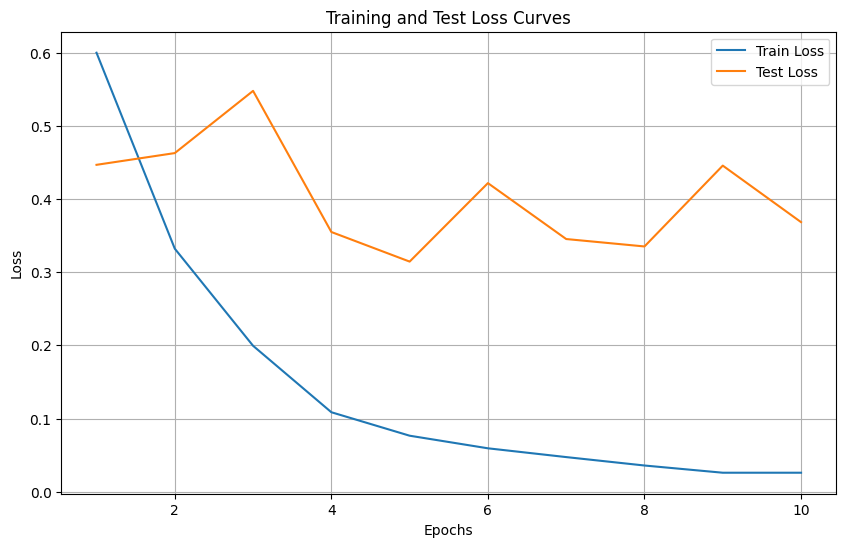

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, test_loss_hist, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

Get confusion matrix

Getting Test Predictions: 100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


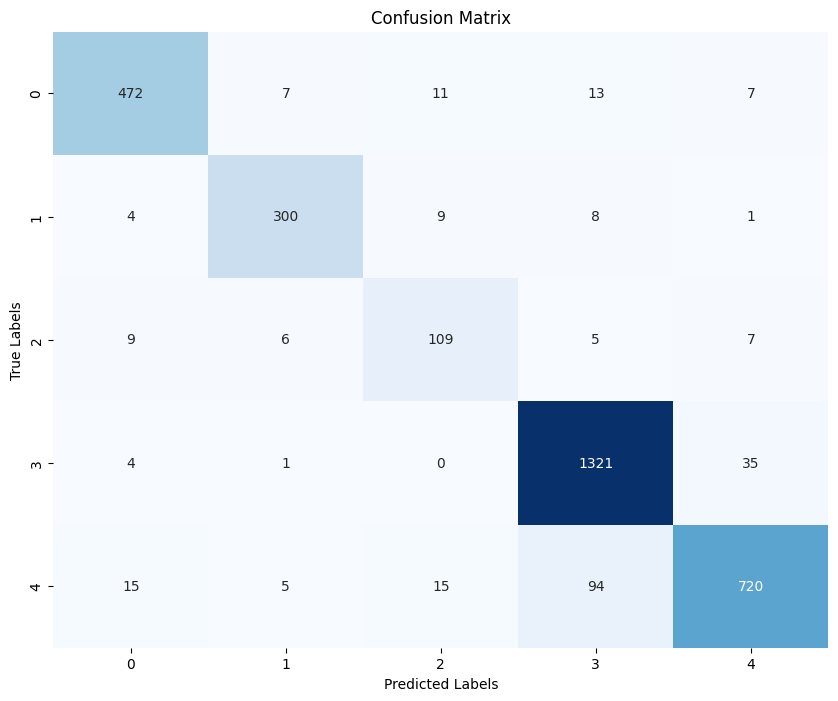

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test dataset
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Getting Test Predictions"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Let's try again with dropout layers and weight decay

In [40]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define your own classifier with dropout
class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomClassifier, self).__init__()
        self.dropout = nn.Dropout(0.2)  # Add dropout with a probability of 0.5
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Load pretrained ResNet-50 model
model_1 = models.resnet50(pretrained=True)

# Replace the classifier with your custom classifier
in_features = model.fc.in_features
num_classes = 5  # Adjust based on your number of classes
custom_classifier = CustomClassifier(in_features, num_classes)
model_1.fc = custom_classifier
model_1.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Your choice of loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
num_epochs = 10
train_loss_hist, train_f1_hist, test_loss_hist, test_f1_hist,  = train(model_1,
                                                                     train_dataloader,
                                                                     test_dataloader,
                                                                     criterion,
                                                                     optimizer,
                                                                     device,
                                                                     num_epochs)

Testing: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


Epoch 1/10 => Train loss: 1.7297, Train F1: 0.1083, Train Acc: 0.1928, Test loss: 1.7242, Test F1: 0.1030, Test Acc: 0.1916


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


Epoch 2/10 => Train loss: 1.7284, Train F1: 0.1093, Train Acc: 0.1943, Test loss: 1.7251, Test F1: 0.0958, Test Acc: 0.1857


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.98it/s]


Epoch 3/10 => Train loss: 1.7293, Train F1: 0.1073, Train Acc: 0.1927, Test loss: 1.7281, Test F1: 0.1002, Test Acc: 0.1888


Testing: 100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Epoch 4/10 => Train loss: 1.7278, Train F1: 0.1093, Train Acc: 0.1941, Test loss: 1.7272, Test F1: 0.1009, Test Acc: 0.1901


Testing: 100%|██████████| 100/100 [00:04<00:00, 20.94it/s]


Epoch 5/10 => Train loss: 1.7288, Train F1: 0.1070, Train Acc: 0.1926, Test loss: 1.7318, Test F1: 0.0952, Test Acc: 0.1847


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.02it/s]


Epoch 6/10 => Train loss: 1.7291, Train F1: 0.1104, Train Acc: 0.1940, Test loss: 1.7280, Test F1: 0.0993, Test Acc: 0.1882


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.18it/s]


Epoch 7/10 => Train loss: 1.7272, Train F1: 0.1080, Train Acc: 0.1941, Test loss: 1.7268, Test F1: 0.1028, Test Acc: 0.1916


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Epoch 8/10 => Train loss: 1.7286, Train F1: 0.1110, Train Acc: 0.1955, Test loss: 1.7349, Test F1: 0.0944, Test Acc: 0.1857


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


Epoch 9/10 => Train loss: 1.7299, Train F1: 0.1092, Train Acc: 0.1931, Test loss: 1.7317, Test F1: 0.0968, Test Acc: 0.1863


Testing: 100%|██████████| 100/100 [00:04<00:00, 21.28it/s]

Epoch 10/10 => Train loss: 1.7282, Train F1: 0.1085, Train Acc: 0.1941, Test loss: 1.7303, Test F1: 0.1013, Test Acc: 0.1897


###looks like that didn't help

# Save original ResNet50 model

In [42]:
torch.save(model.state_dict(), 'model.pth')

In [44]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Plot predictions

In [48]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]



Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 4 (5.Malign)


tensor([[3.4350e-09, 4.0671e-08, 5.8170e-08, 5.6748e-05, 9.9994e-01],
        [9.9997e-01, 1.2188e-05, 3.5148e-06, 1.1387e-05, 5.0027e-06]])

In [49]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 0, 0, 4, 3, 3, 2, 1, 4])

In [50]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([4, 0, 0, 4, 3, 3, 2, 1, 4], tensor([4, 0, 0, 4, 3, 3, 2, 1, 4]))

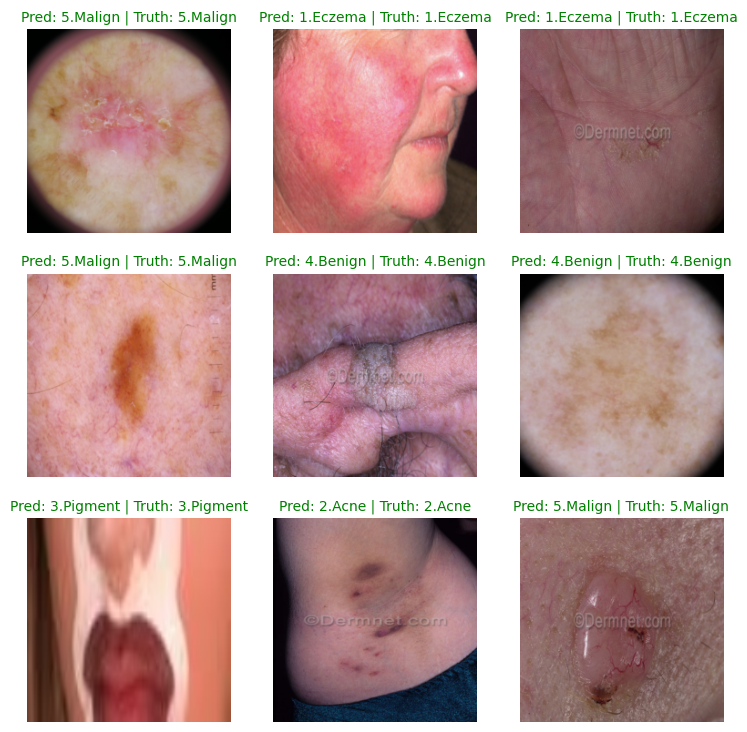

In [53]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze().cpu().numpy().transpose(1,2,0), cmap="gray")

  # Find the prediction label
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);